In [ ]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
df = pd.read_csv('/content/drive/My Drive/drugdata.csv')
df = df.iloc[:, :6]
df = df.dropna()
X = df.iloc[:, :5]
y = df.iloc[:, 5]




In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best CV Score:  -0.00574331364007129
Training Metrics After GridSearch:
MAE: 6.723442369264054e-06
MSE: 1.2337339386716957e-10
RMSE: 0.0000
RRMSE: 0.0021
R²: 0.9995
AAPRE: 45.8759%
RAE: 0.0287

Testing Metrics After GridSearch:
MAE: 3.113871670405455e-05
MSE: 8.209962158731582e-09
RMSE: 0.0001
RRMSE: 0.0297
R²: 0.9492
AAPRE: 70.0842%
RAE: 0.1491


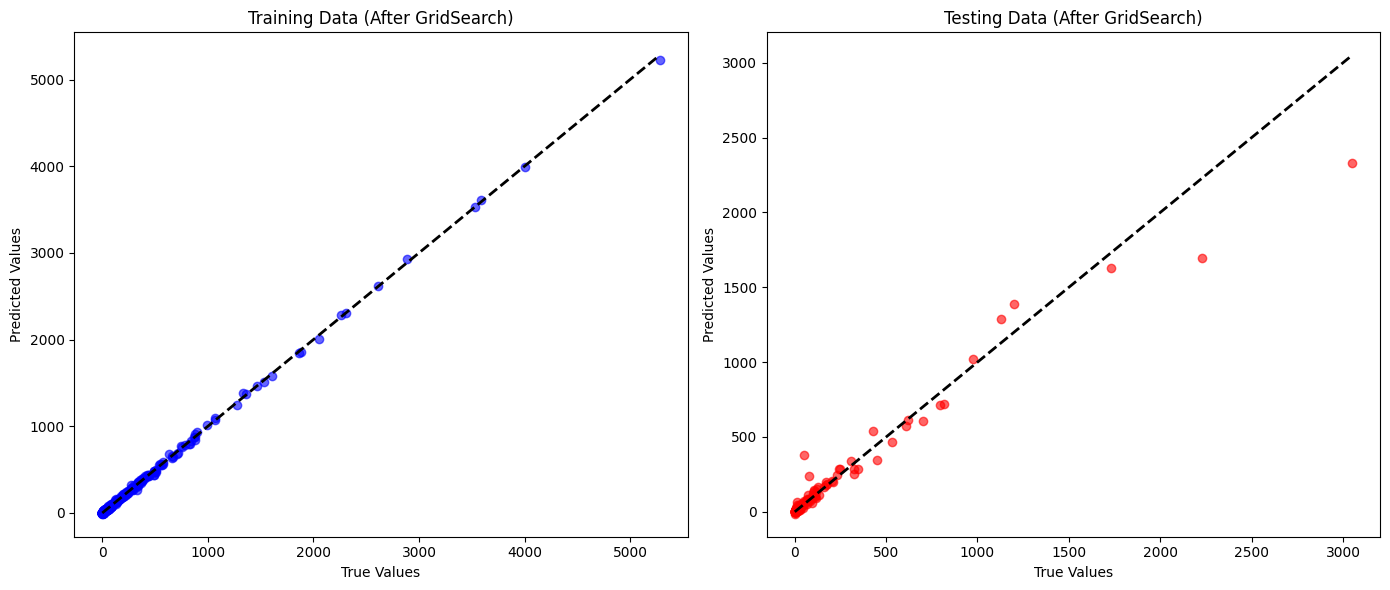

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 220, 250, 280, 300],  # 18 values
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.08, 0.1, 0.12, 0.15, 0.18, 0.2, 0.22, 0.25, 0.3, 0.4, 0.5],  # 15 values
    'max_depth': [3, 4, 5, 6, 7, 8, 9],  # 8 values
}

# Initialize the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Create a custom scoring function using mean_absolute_error
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring=scorer,  # You can also use 'neg_mean_squared_error' or 'r2' for different optimization
                           cv=5,  # 5-fold cross-validation
                           verbose=1,
                           n_jobs=-1)  # Use all available cores

# Fit the model with grid search
grid_search.fit(X_train_scaled, y_train_scaled, validation_fraction=0.15)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best CV Score: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_train_pred_scaled = best_model.predict(X_train_scaled)
y_test_pred_scaled = best_model.predict(X_test_scaled)

# Denormalize the predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Recalculate evaluation metrics
train_mae, train_mse, train_rmse, train_rrmse, train_r2, train_aapre, train_rae = calculate_metrics(y_train / 1000000, y_train_pred / 1000000)
test_mae, test_mse, test_rmse, test_rrmse, test_r2, test_aapre, test_rae = calculate_metrics(y_test / 1000000, y_test_pred / 1000000)

# Print evaluation metrics
print("Training Metrics After GridSearch:")
print(f"MAE: {train_mae}")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_rmse:.4f}")
print(f"RRMSE: {train_rrmse:.4f}")
print(f"R²: {train_r2:.4f}")
print(f"AAPRE: {train_aapre:.4f}%")
print(f"RAE: {train_rae:.4f}\n")

print("Testing Metrics After GridSearch:")
print(f"MAE: {test_mae}")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_rmse:.4f}")
print(f"RRMSE: {test_rrmse:.4f}")
print(f"R²: {test_r2:.4f}")
print(f"AAPRE: {test_aapre:.4f}%")
print(f"RAE: {test_rae:.4f}")

# Plotting
plt.figure(figsize=(14, 6))

# Plot training data
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training Data (After GridSearch)')

# Plot testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='red', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Testing Data (After GridSearch)')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# # Load data
# df = pd.read_csv('/content/drive/My Drive/drugdata_primary_outlierremoval.csv')
# X = df.iloc[:, :5]
# y = df.iloc[:, 5]

# Initialize KFold with 4 splits
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Store the MSE for each fold
fold_mse = []

# Loop over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split the data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the data
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # Initialize and train the XGBoost model
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train_scaled, y_train_scaled)

    # Make predictions
    y_test_pred_scaled = model.predict(X_test_scaled)

    # Denormalize the predictions
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

    # Calculate MSE for this fold
    mse = mean_squared_error(y_test / 1000000, y_test_pred / 1000000)
    fold_mse.append(mse)

    print(f"Fold {fold}: MSE = {mse}")

# Print average MSE over all folds
print(f"\nAverage MSE across all folds: {np.mean(fold_mse)}")

# If you need to use the same partitions for further code, you can save them:
kf_splits = list(kf.split(X))

# Example usage of saved splits:
# Using the first split (Fold 1)
train_index, test_index = kf_splits[0]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Continue with the rest of your code for this fold...


Fold 1: MSE = 6.92578198993583e-09
Fold 2: MSE = 2.4053289854444667e-08
Fold 3: MSE = 1.7168345759378437e-08
Fold 4: MSE = 2.8406778941425657e-09

Average MSE across all folds: 1.2747023874475374e-08
